# Implicit time integration basics

_Highlights_
- a basic example of the implicit Backward Euler method of solving a simple differential equation

## Introduction

This notebook demonstrates the use of Spitfire's implicit time integration methods for solving the simple exponential decay problem introduced in other notebooks.

Following prior demonstrations, we import some useful classes, set up the problem, and solve first with Forward Euler as before.

In [1]:
import numpy as np
from spitfire import Governor, SaveAllDataToList, FinalTime, ForwardEuler

dt = 0.05
tf = 1.0
k = -10.
y0 = np.array([1.])

rhs = lambda t, y: k * y

governor = Governor()
governor.do_logging = False
governor.termination_criteria = FinalTime(tf)

data_fe = SaveAllDataToList(initial_solution=y0, initial_time=0.)
governor.custom_post_process_step = data_fe.save_data

governor.integrate(right_hand_side=lambda t, y: k * y,
                   initial_condition=y0,
                   controller=PIController(target_error=1.e-8, first_step=1.e-3, max_step=1.e-1),
                   method=ForwardEuler())

NameError: name 'PIController' is not defined

To solve with the implicit Backward Euler method, we import the `BackwardEuler` and `SimpleNewtonSolver` classes.
`BackwardEuler` is the time stepper class and `SimpleNewtonSolver` will be the underlying solver for the nonlinear system of equations solved in each time step.

Note from the output of `integrate` in this case that we now have nontrivial numbers for the `nonlinear iter`, `linear iter`, and `Jacobian setups` fields. These aren't particularly interesting in this case because the exponential decay problem is linear and we haven't set up any advanced solution options. We'll cover these in a later notebook.

The only distinction between using this implicit method and the explicit methods used before is that the ``BackwardEuler`` instance is built with a ``SimpleNewtonSolver`` object when passed to `integrate`.
This simplicity is present in this case because we are letting Spitfire use a default dense linear solver (LU factorization and back-substitution with LAPACK) and a finite difference approximation to the Jacobian matrix of the system.
In cases where a dense solver and approximate Jacobian matrix are appropriate, this is a very convenient option.
However, in many cases of practical interest this is not efficient and more advanced options need to be explored - these will be covered in later demonstrations.

In [2]:
from spitfire import BackwardEuler, SimpleNewtonSolver

data_be = SaveAllDataToList(initial_solution=y0, initial_time=0.)
governor.custom_post_process_step = data_be.save_data

governor.integrate(right_hand_side=lambda t, y: k * y,
                   initial_condition=y0,
                   controller=dt,
                   method=BackwardEuler(SimpleNewtonSolver()))

({'time steps': 20,
  'simulation time': array(1.),
  'nonlinear iter': 21,
  'linear iter': 21,
  'Jacobian setups': 20,
  'total cpu time (s)': 0.14858286606613547},
 array([0.00030073]),
 array(1.),
 0.05)

Now we can just as easily use the more advanced `ESDIRK64` method. This method is the workhorse of Spitfire's solvers for complex chemistry problems and is extremely useful as a general solver. It is fourth-order accurate and possesses excellent characteristics such as L-stability, a stage order of two (due to the explicit first stage), and singly diagonally implicit solves meaning that its embedded linear systems may be solved much more efficiently than those of fully implicit Runge-Kutta methods with comparable properties.

In [3]:
from spitfire import ESDIRK64

data_rk = SaveAllDataToList(initial_solution=y0, initial_time=0.)
governor.custom_post_process_step = data_rk.save_data

governor.integrate(right_hand_side=lambda t, y: k * y,
                   initial_condition=y0,
                   controller=dt,
                   method=ESDIRK64(SimpleNewtonSolver()))

({'time steps': 20,
  'simulation time': array(1.),
  'nonlinear iter': 100,
  'linear iter': 100,
  'Jacobian setups': 20,
  'total cpu time (s)': 0.01021978398784995},
 array([4.54245552e-05]),
 array(1.),
 0.05)

Plotting the solutions from the Forward and Backward Euler methods along with the exact solution shows that the two methods yield exactly opposite errors.
When the nonlinear system in Backward Euler's time steps can be solved exactly this is consistent with theory.
This also shows that the Runge Kutta method is exceptionally accurate.

<IPython.core.display.Javascript object>


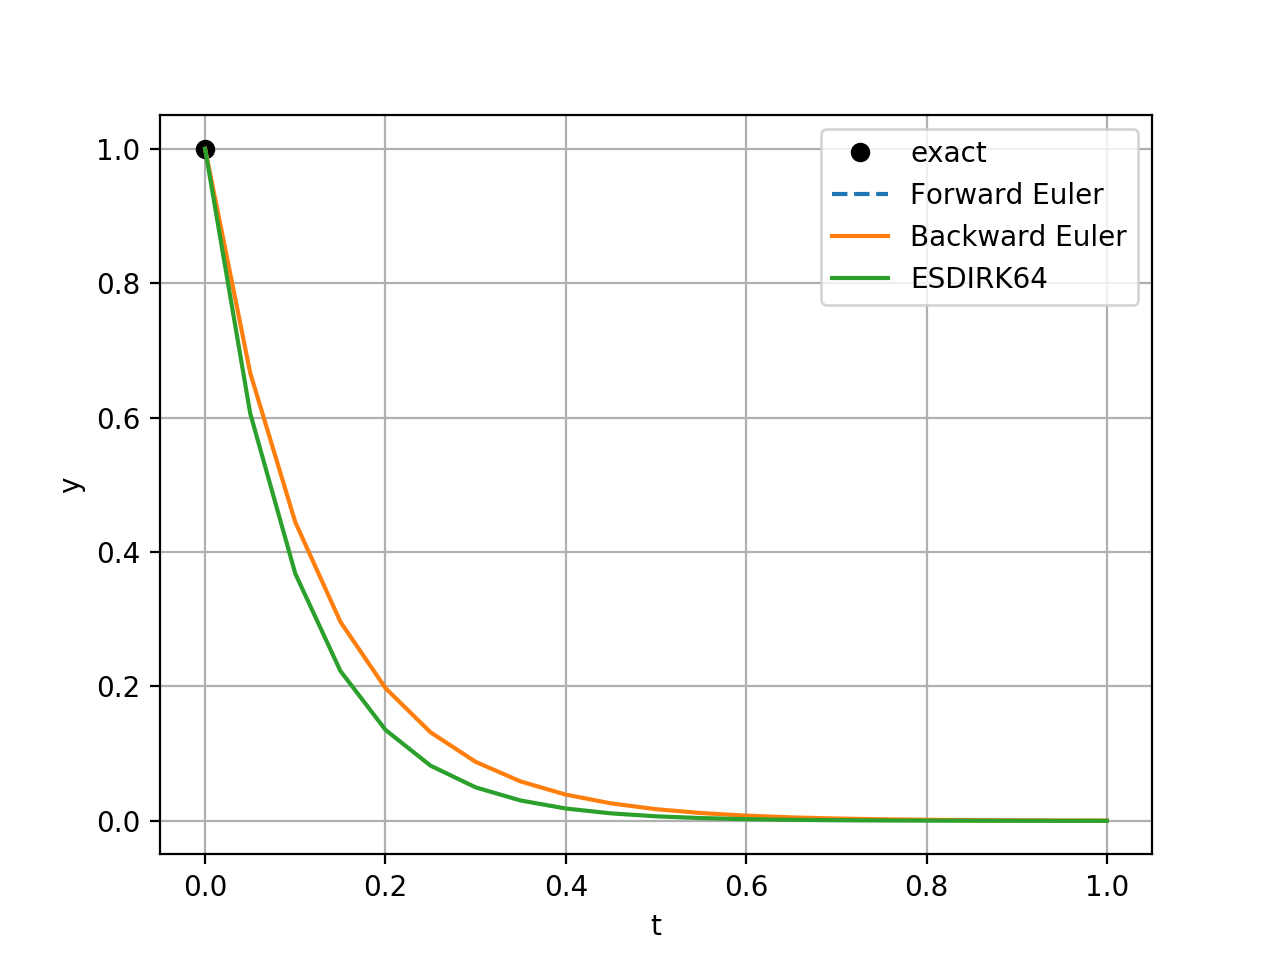

In [4]:
import matplotlib.pyplot as plt

%matplotlib notebook
plt.plot(data_fe.t_list, y0 * np.exp(k * data_fe.t_list), 'ko', label='exact')
plt.plot(data_fe.t_list, data_fe.solution_list, '--', label='Forward Euler')
plt.plot(data_be.t_list, data_be.solution_list, '-', label='Backward Euler')
plt.plot(data_rk.t_list, data_rk.solution_list, '-', label='ESDIRK64')

plt.xlabel('t')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid()
plt.show()

## Conclusions

This notebook shows the simplest use of some implicit time-stepping methods, including a high-order Runge-Kutta method, with Spitfire. Implicit methods can perform extremely well for many classes of problems when fine-tuned - examples of such fine-tuning will follow in more advanced demonstrations.